In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from tqdm import tqdm

Parameters

In [ ]:
NUM_EPOCHS = 25
BATCH_SIZE = 32
LEARNING_RATE = 0.001
path_DS = 'raw-img'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Define transformations

In [81]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

Dataset

In [ ]:
dataset = datasets.ImageFolder(root=path_DS, transform=transform)
num_classes = len(dataset.classes)
print(num_classes)

10


Split dataset

In [84]:
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size 
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Data loaders

In [85]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


CNN 

In [91]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

Initialize model, loss, optimizer

In [92]:
model = SimpleCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

Training

In [ ]:

def train_model():
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss, correct, total = 0, 0, 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}: Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        scheduler.step()
    
    return train_losses, train_accs, val_losses, val_accs


In [94]:
train_losses, train_accs, val_losses, val_accs = train_model()

Epoch 1/25: 100%|██████████| 655/655 [01:50<00:00,  5.94it/s]


Epoch 1: Train Loss: 1.9914, Train Acc: 0.2893, Val Loss: 1.7805, Val Acc: 0.3653


Epoch 2/25: 100%|██████████| 655/655 [01:30<00:00,  7.22it/s]


Epoch 2: Train Loss: 1.7114, Train Acc: 0.3994, Val Loss: 1.5524, Val Acc: 0.4635


Epoch 3/25: 100%|██████████| 655/655 [01:30<00:00,  7.20it/s]


Epoch 3: Train Loss: 1.5681, Train Acc: 0.4584, Val Loss: 1.4221, Val Acc: 0.5067


Epoch 4/25: 100%|██████████| 655/655 [01:31<00:00,  7.17it/s]


Epoch 4: Train Loss: 1.4610, Train Acc: 0.4970, Val Loss: 1.3161, Val Acc: 0.5384


Epoch 5/25: 100%|██████████| 655/655 [01:31<00:00,  7.15it/s]


Epoch 5: Train Loss: 1.3768, Train Acc: 0.5307, Val Loss: 1.3296, Val Acc: 0.5395


Epoch 6/25: 100%|██████████| 655/655 [01:31<00:00,  7.16it/s]


Epoch 6: Train Loss: 1.3243, Train Acc: 0.5504, Val Loss: 1.2079, Val Acc: 0.5797


Epoch 7/25: 100%|██████████| 655/655 [01:31<00:00,  7.16it/s]


Epoch 7: Train Loss: 1.2685, Train Acc: 0.5689, Val Loss: 1.2785, Val Acc: 0.5598


Epoch 8/25: 100%|██████████| 655/655 [01:32<00:00,  7.11it/s]


Epoch 8: Train Loss: 1.2292, Train Acc: 0.5818, Val Loss: 1.1833, Val Acc: 0.6011


Epoch 9/25: 100%|██████████| 655/655 [01:31<00:00,  7.12it/s]


Epoch 9: Train Loss: 1.1761, Train Acc: 0.6020, Val Loss: 1.1795, Val Acc: 0.5965


Epoch 10/25: 100%|██████████| 655/655 [01:31<00:00,  7.13it/s]


Epoch 10: Train Loss: 1.1457, Train Acc: 0.6143, Val Loss: 1.1451, Val Acc: 0.6022


Epoch 11/25: 100%|██████████| 655/655 [01:31<00:00,  7.13it/s]


Epoch 11: Train Loss: 1.0446, Train Acc: 0.6451, Val Loss: 1.0080, Val Acc: 0.6496


Epoch 12/25: 100%|██████████| 655/655 [01:31<00:00,  7.14it/s]


Epoch 12: Train Loss: 1.0216, Train Acc: 0.6530, Val Loss: 1.0223, Val Acc: 0.6462


Epoch 13/25: 100%|██████████| 655/655 [01:31<00:00,  7.19it/s]


Epoch 13: Train Loss: 1.0120, Train Acc: 0.6575, Val Loss: 1.0297, Val Acc: 0.6523


Epoch 14/25: 100%|██████████| 655/655 [01:31<00:00,  7.16it/s]


Epoch 14: Train Loss: 1.0000, Train Acc: 0.6622, Val Loss: 0.9854, Val Acc: 0.6584


Epoch 15/25: 100%|██████████| 655/655 [01:31<00:00,  7.14it/s]


Epoch 15: Train Loss: 0.9896, Train Acc: 0.6632, Val Loss: 0.9903, Val Acc: 0.6580


Epoch 16/25: 100%|██████████| 655/655 [01:31<00:00,  7.18it/s]


Epoch 16: Train Loss: 0.9914, Train Acc: 0.6661, Val Loss: 0.9742, Val Acc: 0.6691


Epoch 17/25: 100%|██████████| 655/655 [01:31<00:00,  7.19it/s]


Epoch 17: Train Loss: 0.9841, Train Acc: 0.6685, Val Loss: 0.9758, Val Acc: 0.6683


Epoch 18/25: 100%|██████████| 655/655 [01:30<00:00,  7.21it/s]


Epoch 18: Train Loss: 0.9772, Train Acc: 0.6695, Val Loss: 0.9713, Val Acc: 0.6664


Epoch 19/25: 100%|██████████| 655/655 [01:30<00:00,  7.23it/s]


Epoch 19: Train Loss: 0.9649, Train Acc: 0.6722, Val Loss: 0.9674, Val Acc: 0.6656


Epoch 20/25: 100%|██████████| 655/655 [01:31<00:00,  7.17it/s]


Epoch 20: Train Loss: 0.9609, Train Acc: 0.6760, Val Loss: 0.9575, Val Acc: 0.6687


Epoch 21/25: 100%|██████████| 655/655 [01:31<00:00,  7.17it/s]


Epoch 21: Train Loss: 0.9489, Train Acc: 0.6796, Val Loss: 0.9608, Val Acc: 0.6695


Epoch 22/25: 100%|██████████| 655/655 [01:31<00:00,  7.20it/s]


Epoch 22: Train Loss: 0.9570, Train Acc: 0.6754, Val Loss: 0.9372, Val Acc: 0.6806


Epoch 23/25: 100%|██████████| 655/655 [01:31<00:00,  7.17it/s]


Epoch 23: Train Loss: 0.9474, Train Acc: 0.6797, Val Loss: 0.9665, Val Acc: 0.6679


Epoch 24/25: 100%|██████████| 655/655 [01:31<00:00,  7.19it/s]


Epoch 24: Train Loss: 0.9534, Train Acc: 0.6764, Val Loss: 0.9556, Val Acc: 0.6767


Epoch 25/25: 100%|██████████| 655/655 [01:33<00:00,  7.03it/s]


Epoch 25: Train Loss: 0.9480, Train Acc: 0.6777, Val Loss: 0.9587, Val Acc: 0.6756


# Results

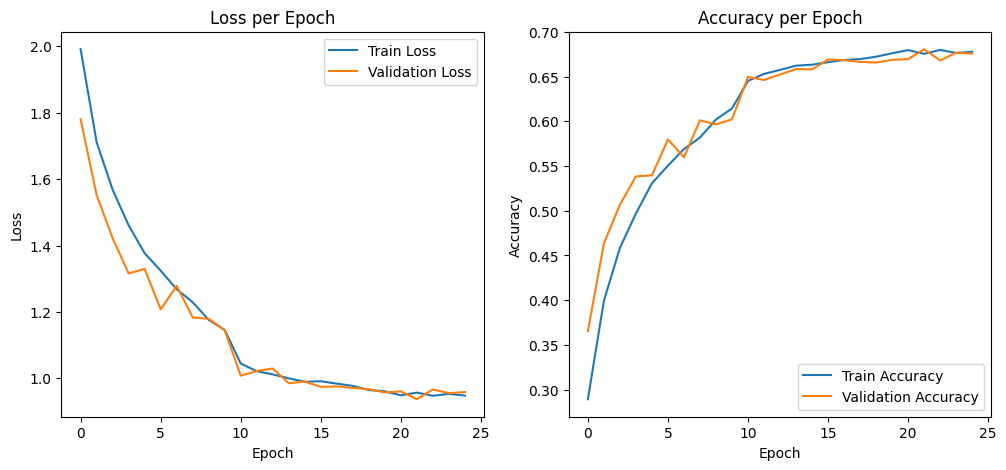

In [97]:
def plot_metrics():
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss per Epoch')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy per Epoch')
    
plot_metrics()

# Save model
torch.save(model.state_dict(), 'animal_classifierVER2.pth')